In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, "../")

## Import

In [3]:
from collections import OrderedDict
import numpy
import pandas

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier

In [4]:
from utils import get_N_B_events, predict_by_estimator, bootstrap_calibrate_prob
from utils import get_events_number, get_events_statistics, result_table, compute_mistag, shrink_floats_xgb

## Reading initial data

In [8]:
import root_numpy
def read_samples(filename, filename_vtx, filename_splot):
    splot = pandas.read_csv(filename_splot, sep=' ', header=None).drop([8], axis=1)
    splot.columns = ['run', 'evTop', 'evBottom', 'Bmass', 'Nbkg_tot_sw', 'L_Nbkg_tot', 'Nsig_tot_sw', 'L_Nsig_tot']
    event_id_column = 'event_id'

    splot[event_id_column] = splot.run.apply(str) + '_' + (splot.evTop * 1e6 + splot.evBottom).apply(int).apply(str)
    index = numpy.unique(splot[event_id_column], return_index=True)[1]
    splot.index = numpy.arange(len(splot))
    splot = splot.ix[index, :]
    splot.index = splot[event_id_column]
    
    data = pandas.read_csv(filename, sep='\t')
    data = data.query('(Bmass < 5.4) & (Bmass > 5.16) & ((K_cut == 1) | (mu_cut == 1) | (e_cut == 1))')

    data_vertex = pandas.read_csv(filename_vtx, sep='\t')
    data_vertex = data_vertex.query('(Bmass < 5.4) & (Bmass > 5.16) & (v_cut == 1) & (vcharge > 0.2)')
    
    datasets = dict()
    for name, selection, data_temp in zip(['K', 'e', 'mu', 'vtx'], 
                                          ['K_cut == 1', 'e_cut == 1', 'mu_cut == 1', ""],
                                          [data] * 3 + [data_vertex]):
        if selection != "":
            data_temp = data_temp.query(selection)
        shrink_floats_xgb(data_temp)        
        if name == 'vtx':
            data_temp['label'] = (data_temp.signB.values * data_temp.signVtx.values < 0) * 1
        else:
            data_temp['label'] = (data_temp.signB.values * data_temp.signTrack.values < 0) * 1
        data_temp['event_id'] = data_temp.run.apply(str) + '_' + data_temp.event.apply(int).apply(str)
        data_temp['tagAnswer'] = data_temp.signB * (2 * data_temp.label - 1)
        data_temp.index = data_temp["event_id"]
        data_temp['N_sig_sw'] = splot.loc[data_temp.index, 'Nsig_tot_sw']
        datasets[name] = data_temp
    
    return datasets, sum(splot.Nsig_tot_sw.values)

In [9]:
def compute_efficiencies(datasets, N_B_events):
    result = dict()
    for key, data in datasets.items():
        N_B_passed = get_events_number(data)
        result[key] = (1. * N_B_passed / N_B_events, sqrt(N_B_passed) / N_B_events)
    return result

In [10]:
datasets, N_B_events = read_samples('../datasets/data/csv/WG/Bu_JPsiK/2012/Tracks.csv', 
                                    '../datasets/data/csv/WG/Bu_JPsiK/2012/Vertices.csv', 
                                    '../datasets/data/csv/WG/Bu_JPsiK/2012/sPlot_Bu_JPsiK.csv')

/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [14]:
datasets_kstar, N_B_events_kstar = read_samples('../datasets/data/csv/WG/Bd_JPsiKstar/2012/Tracks.csv', 
                                                '../datasets/data/csv/WG/Bd_JPsiKstar/2012/Vertices.csv', 
                                                '../datasets/data/csv/WG/Bd_JPsiKstar/2012/sPlot_Bd_JPsiKstar.csv')

/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

## Calculate $\epsilon_{tag}$ for each datasets

In [15]:
eff = compute_efficiencies(datasets, N_B_events)
eff_kstar = compute_efficiencies(datasets_kstar, N_B_events_kstar)

In [16]:
print 'K+-'
print pandas.DataFrame(eff)
print 'K*'
print pandas.DataFrame(eff_kstar)

K+-
          K         e        mu       vtx
0  0.122194  0.021844  0.056905  0.120291
1  0.000418  0.000177  0.000285  0.000415
K*
          K         e        mu       vtx
0  0.126019  0.022164  0.058557  0.122501
1  0.000672  0.000282  0.000458  0.000663


## Features used in training

In [17]:
features_vtx = ['mult', 'nnkrec', 'log_ptB: log(ptB)', 'vflag', 'log_ipsmean: log(ipsmean)', 
                'log_ptmean: log(ptmean)', 'vcharge', 
                'log_svm: log(svm)', 'log_svp: log(svp)', 'BDphiDir', 'log_svtau: log(svtau)', 'docamax']

features_ele = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'log_eOverP: log(EOverP)', 
                'ghostProb', 'log_IPPU: log(IPPU)']
features_muon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'PIDNNm', 'ghostProb', 'log_IPPU: log(IPPU)']
features_kaon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                 'nnkrec','log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 
                'PIDNNk', 'PIDNNpi', 'PIDNNp', 'ghostProb', 'log_IPPU: log(IPPU)']
                                    
features = {'e': features_ele, 'mu': features_muon,
            'K': features_kaon, 'vtx': features_vtx}

In [18]:
estimators = OrderedDict()

### XGBoost

In [ ]:
from rep.estimators import XGBoostClassifier
from rep.metaml import FoldingClassifier

xgb_base_ele = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=12, 
                                 n_estimators=200, subsample=0.3, max_depth=5) 

xgb_base_other = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=12, 
                                   n_estimators=500, subsample=0.3, max_depth=3) 

for key, data in datasets.items():
    if 'e' in key:
        xgb_base = xgb_base_ele
    else:
        xgb_base = xgb_base_other
        
    estimators[key + '_xgboost'] = FoldingClassifier(xgb_base, n_folds=2, random_state=11,
                                                     features=features[key])
    estimators[key + '_xgboost'].fit(data, data['label'], data['N_sig_sw'])

### TMVA

In [ ]:
from rep.estimators import TMVAClassifier
from rep.metaml import FoldingClassifier

tmva_base_muon = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N:Silent', sigmoid_function='identity',
                                NeuronType='tanh', NCycles=280, HiddenLayers='N+5', TrainingMethod='BFGS', TestRate=5,
                                UseRegulator=True, EstimatorType='CE')

tmva_base_ele = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N:Silent', sigmoid_function='identity',
                               NeuronType='sigmoid', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                               UseRegulator=True)

tmva_base_kaon_vtx = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N:Silent', 
                                    sigmoid_function='identity',
                                    NeuronType='tanh', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                                    UseRegulator=True, EstimatorType='CE')


for key, data in datasets.items():
    if 'e' in key:
        tmva_base = tmva_base_ele
    elif 'mu' in key:
        tmva_base = tmva_base_muon
    else:
        tmva_base = tmva_base_kaon_vtx
    estimators[key + '_tmva'] = FoldingClassifier(tmva_base, n_folds=2, random_state=11,
                                                  features=features[key])
    estimators[key + '_tmva'].fit(data, data['label'], data['N_sig_sw'])

In [ ]:
import cPickle
with open('../models/old-tagging-WG.pkl', 'r') as f:
    estimators = cPickle.load(f)

In [ ]:
import cPickle
with open('../models/old-tagging-WG.pkl', 'w') as f:
    cPickle.dump(estimators, f)

In [ ]:
estimators.keys()

['mu_xgboost',
 'vtx_xgboost',
 'K_xgboost',
 'e_xgboost',
 'mu_tmva',
 'vtx_tmva',
 'K_tmva',
 'e_tmva']

In [ ]:
for key in datasets.keys():
    for suffix in ['_xgboost', '_tmva']:
        name = key + suffix
        probs = estimators[name].predict_proba(datasets[key])[:, 1]        
        print name, label, 'AUC:', roc_auc_score(datasets[key]['label'].values, 
                                                 probs, sample_weight=datasets[key]['N_sig_sw'].values)

KFold prediction using folds column
mu_xgboost K+- AUC: 0.602239696051
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_xgboost K* AUC: 0.611715151984
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_xgboost Ks AUC: 0.60907181786
KFold prediction using folds column
mu_tmva K+- AUC: 0.592810717311
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_tmva K* AUC: 0.598372122464
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_tmva Ks AUC: 0.607212728002
KFold prediction using random classifier (length of data passed not equal to length of train)
vtx_xgboost K+- AUC: 0.591992616996
KFold prediction using random classifier (length of data passed not equal to length of train)
vtx_xgboost K* AUC: 0.584552237243
KFold prediction using random classifier (length of data passed not equal to length of train)
vtx

--------

## Calculate quality for each tagger (ele, muon, kaon, vtx)

using isotonic final calibration with bootstrap

In [ ]:
from utils import predict_by_estimator, calibrate_probs, run_taggers_combination

def combine(estimators, datasets, keys, N_B_events, logistic=False,
            return_calibrations=False, logistic_combined=True, model_name=None, with_roc=False):
    """
    :param suffix: suffix used for taggers
    :param model_name: name for model after combining classifiers
    """
    data_with_predictions = {}
    calibrators_tracks = dict()
    
    # computing calibrated predictions of each tagger
    for key in keys:
        data, probs = predict_by_estimator(estimators[key], [datasets[key]])
        probs_calibrated, calibrators_tracks[key] = \
            calibrate_probs(data.label.values, data.N_sig_sw.values, probs, logistic=logistic)
            
        ids = numpy.array(data['event_id'])
        data_with_predictions[key] = pandas.DataFrame({'prob_{}'.format(key): probs_calibrated, 
                                                       'tag_{}'.format(key): data.tagAnswer.values,
                                                       'weight': data.N_sig_sw.values,
                                                       'signB': data.signB.values}, index=ids)
        
    calibrator_B, table, roc = run_taggers_combination(data_with_predictions, keys, N_B_events, 
                                                       model_name=','.join(keys) if model_name is None else model_name, 
                                                       logistic_combined=logistic_combined)
    if return_calibrations and with_roc:
        return table, calibrators_tracks, calibrator_B, roc
    elif return_calibrations and not with_roc:
        return table, calibrators_tracks, calibrator_B
    elif with_roc:
        return table, roc
    else:
        return table

### TMVA

In [ ]:
test_estimators_tmva = dict((key, estimators[key + '_tmva']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.726296637275 AUC with untag: 0.518452584724


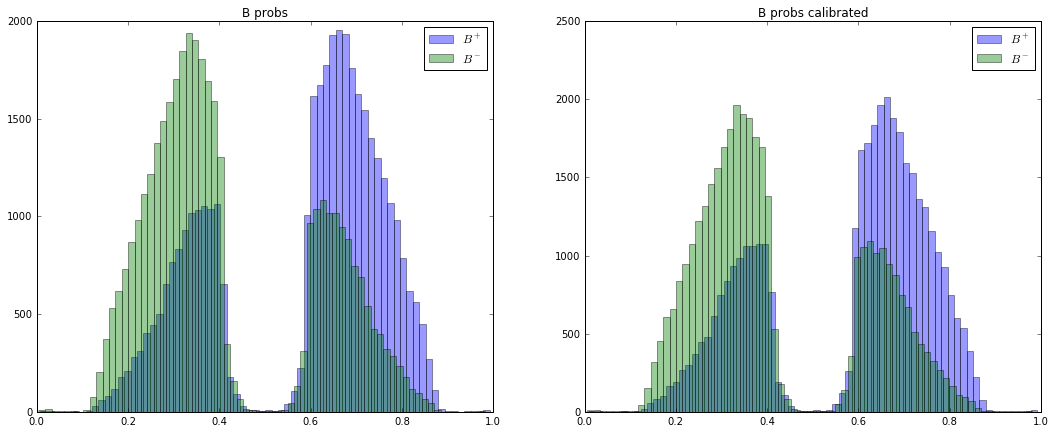

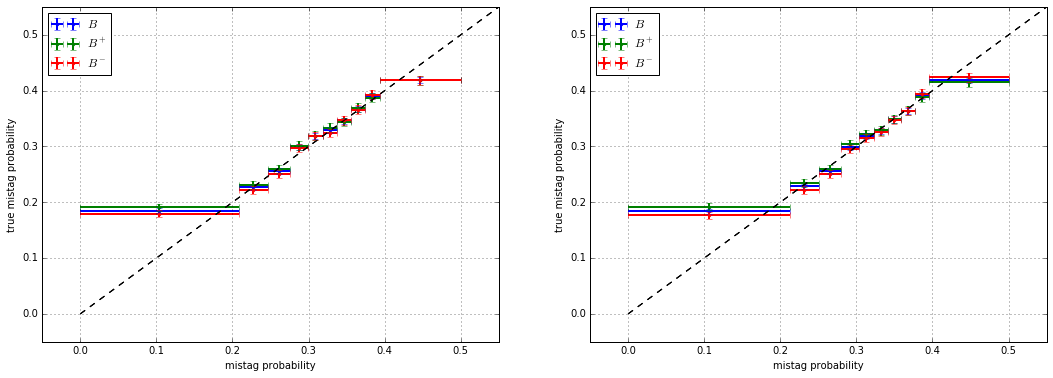

Efficiency, not calibrated 0.833886728183
Average AUC 0.726257934914 6.01150502625e-05
KFold prediction using random classifier (length of data passed not equal to length of train)
AUC for tagged: 0.660492890035 AUC with untag: 0.532321088691


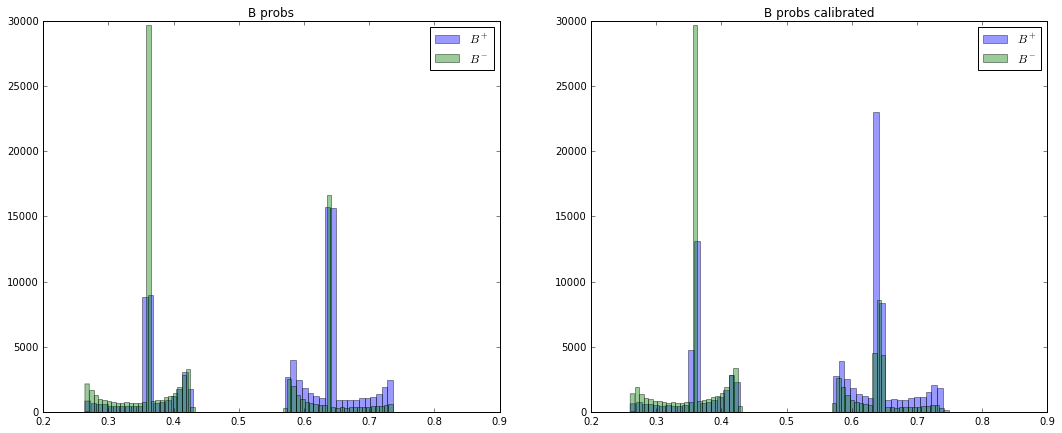

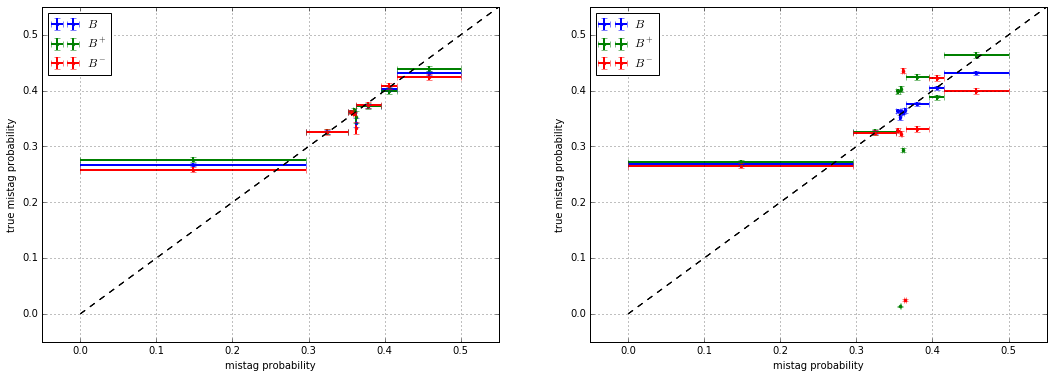

Efficiency, not calibrated 1.02462212873
Average AUC 0.660435258973 0.000142383721261
KFold prediction using folds column
AUC for tagged: 0.681889139548 AUC with untag: 0.551436691355


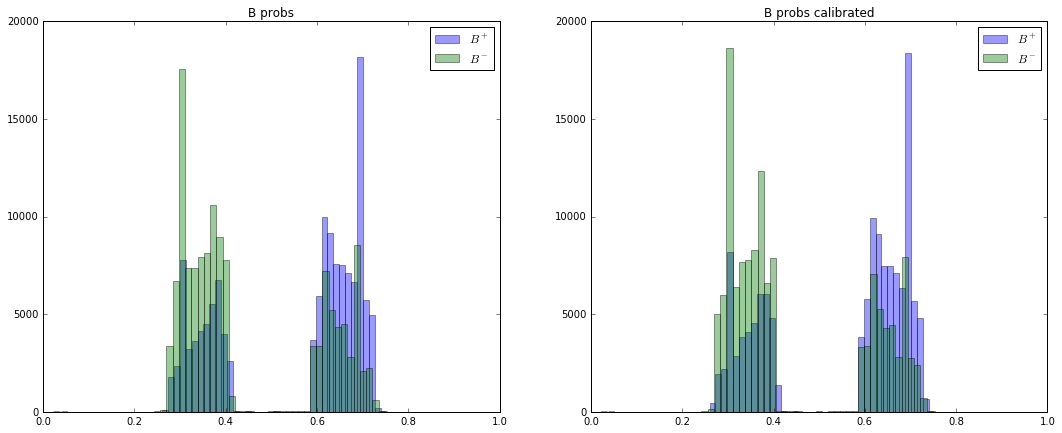

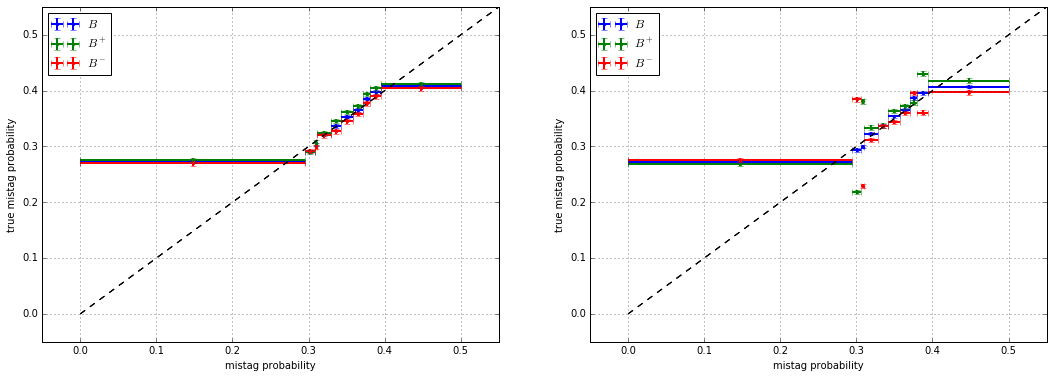

Efficiency, not calibrated 1.83434022815
Average AUC 0.681819287131 6.57229195855e-05
KFold prediction using folds column
AUC for tagged: 0.693098090779 AUC with untag: 0.506599671677


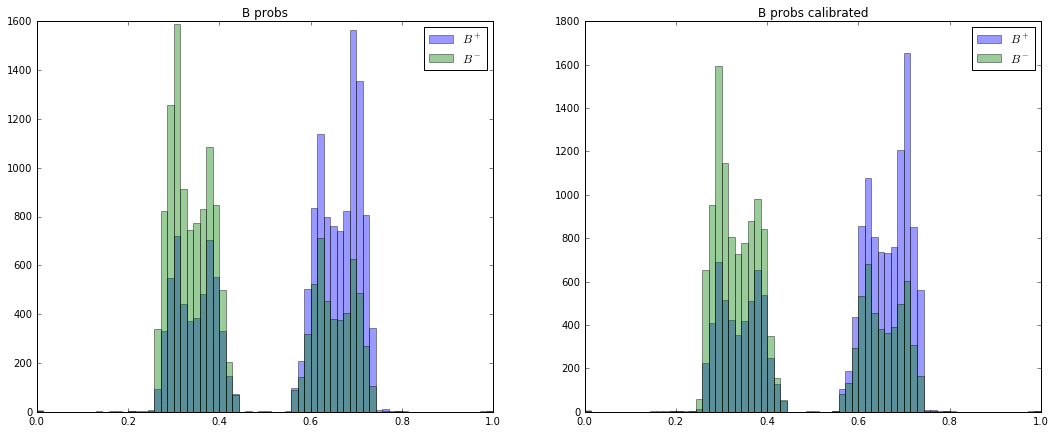

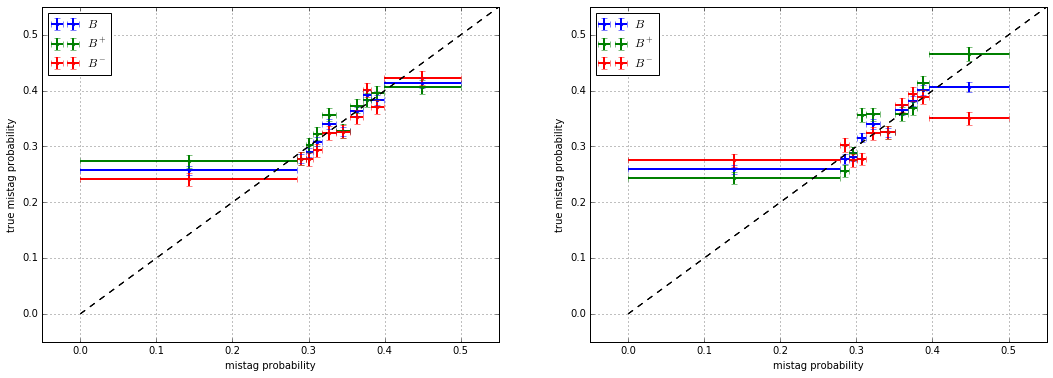

Efficiency, not calibrated 0.225473667552
Average AUC 0.692923487639 0.000187958949242


In [ ]:
figsize(18, 7)

results_separate_tmva = []
for key in datasets.keys(): 
    x = combine(test_estimators_tmva, datasets, [key], N_B_events, logistic=True)
    results_separate_tmva.append(x)

In [ ]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.158149,0.001362,0.799256,0.007474,51.845258,0
0,vtx,12.265035,0.028701,0.084337,0.000383,1.034393,0.005280,53.232109,0
0,K,17.759661,0.034537,0.105538,0.000387,1.874317,0.007774,55.143669,0
0,e,2.023049,0.011657,0.116528,0.001254,0.235741,0.002877,50.659967,0


### XGBoost

In [ ]:
test_estimators = dict((key, estimators[key + '_xgboost']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.730335879047 AUC with untag: 0.518433566221


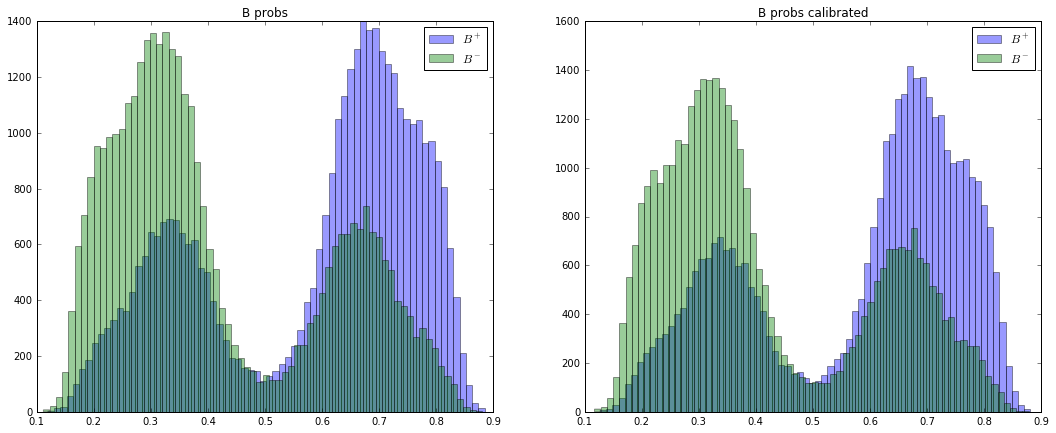

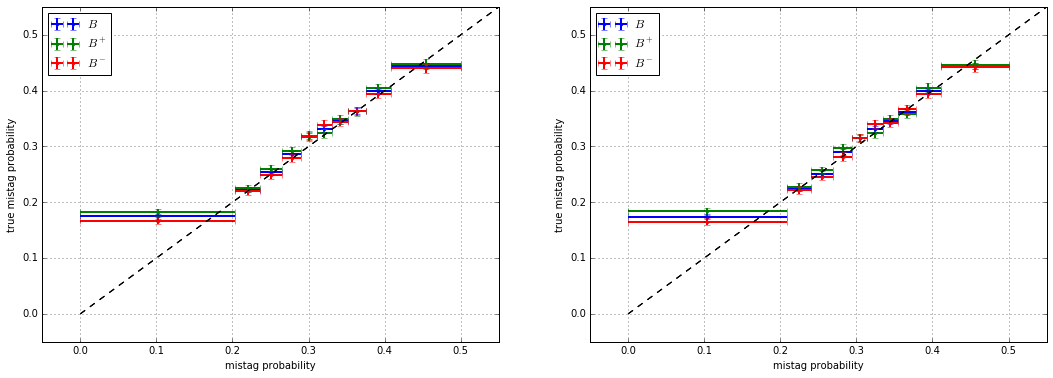

Efficiency, not calibrated 0.855666533161
Average AUC 0.730299445453 5.64256048636e-05
KFold prediction using random classifier (length of data passed not equal to length of train)
AUC for tagged: 0.681227634457 AUC with untag: 0.532432632795


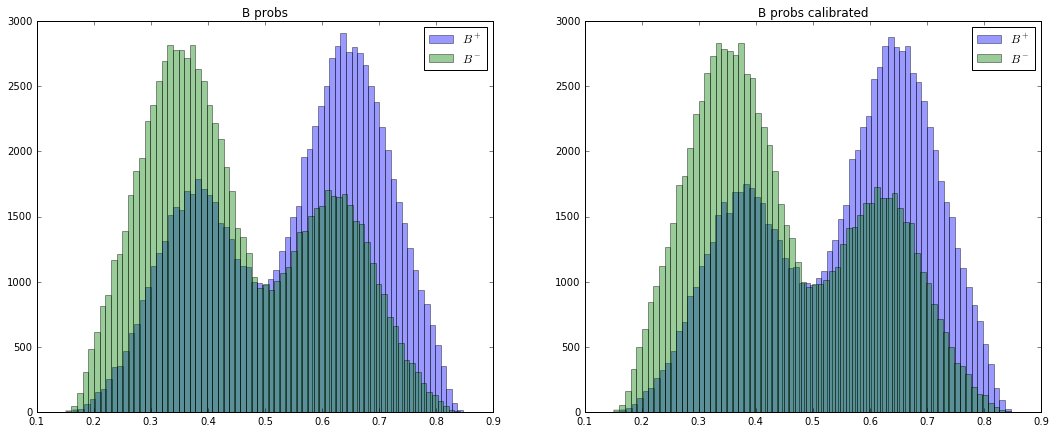

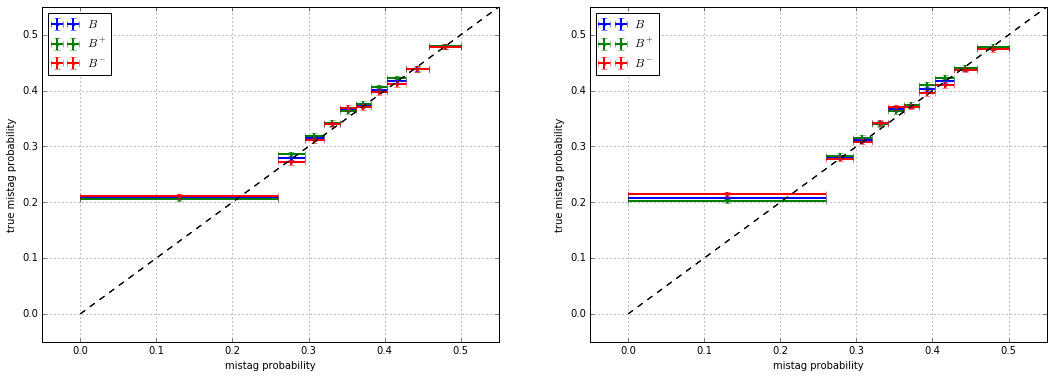

Efficiency, not calibrated 1.22466755565
Average AUC 0.681214107839 1.68725851506e-05
KFold prediction using folds column
AUC for tagged: 0.690404049895 AUC with untag: 0.551665472144


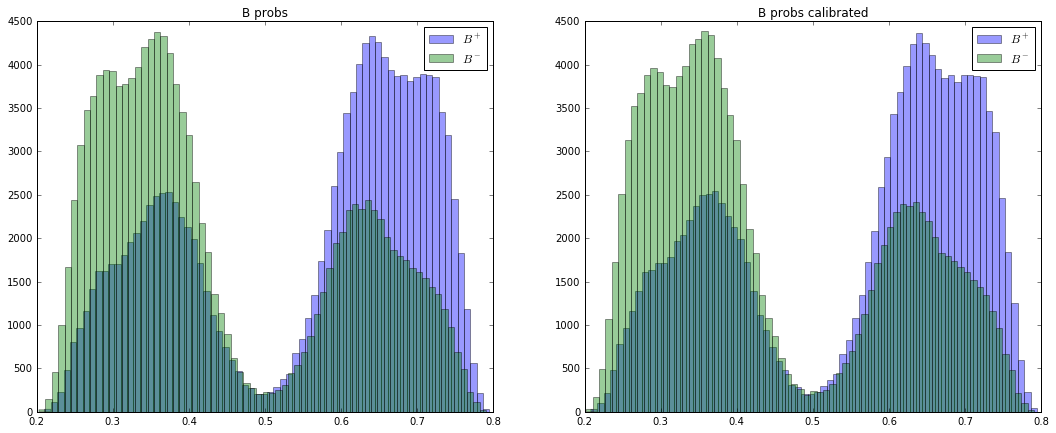

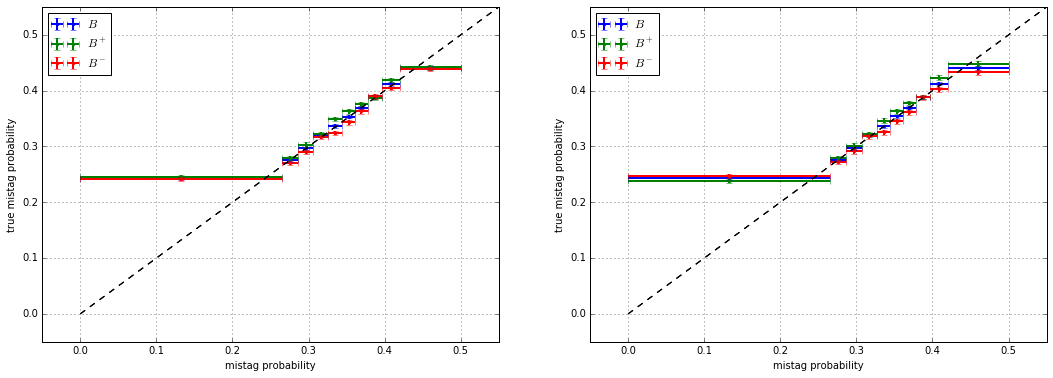

Efficiency, not calibrated 1.98500824445
Average AUC 0.690387470038 2.24218114276e-05
KFold prediction using folds column
AUC for tagged: 0.703729521828 AUC with untag: 0.506582964707


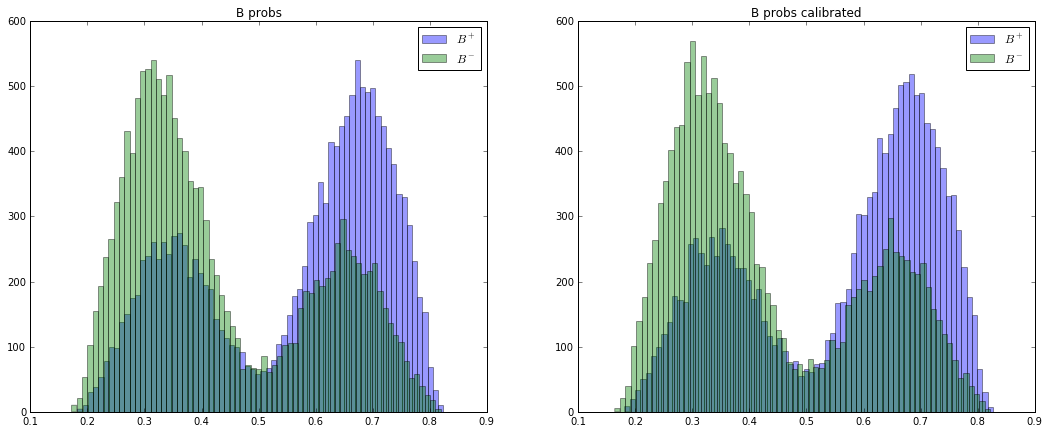

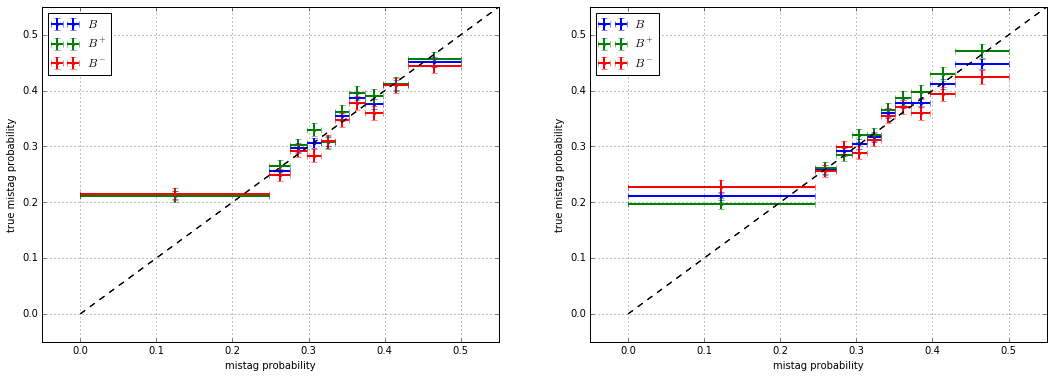

Efficiency, not calibrated 0.251125560953
Average AUC 0.703628765177 0.000120501215994


In [ ]:
figsize(18, 7)

calibrators_B = dict()
calibrator_tracks = dict()

results_separate = []
for key in datasets.keys(): 
    x, calibrator_tracks[key], calibrators_B[key] = combine(test_estimators, datasets, [key], N_B_events,
                                                            logistic=True, return_calibrations=True)
    results_separate.append(x)

In [ ]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162675,0.001553,0.822131,0.008400,51.843357,0
0,vtx,12.265035,0.028701,0.099969,0.000478,1.226123,0.006527,53.243263,0
0,K,17.759661,0.034537,0.111957,0.000410,1.988317,0.008241,55.166547,0
0,e,2.023049,0.011657,0.127795,0.001335,0.258536,0.003085,50.658296,0


# Combination of all taggers

### TMVA

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
AUC for tagged: 0.689299586725 AUC with untag: 0.577786323247


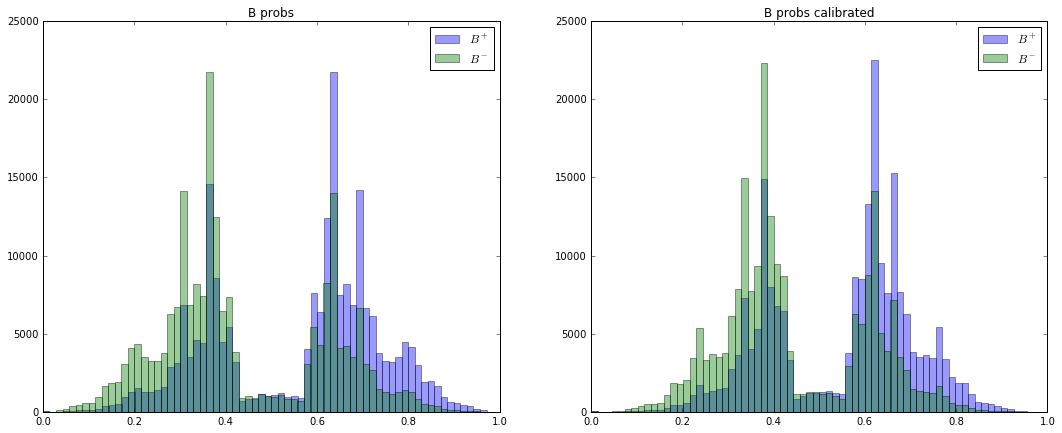

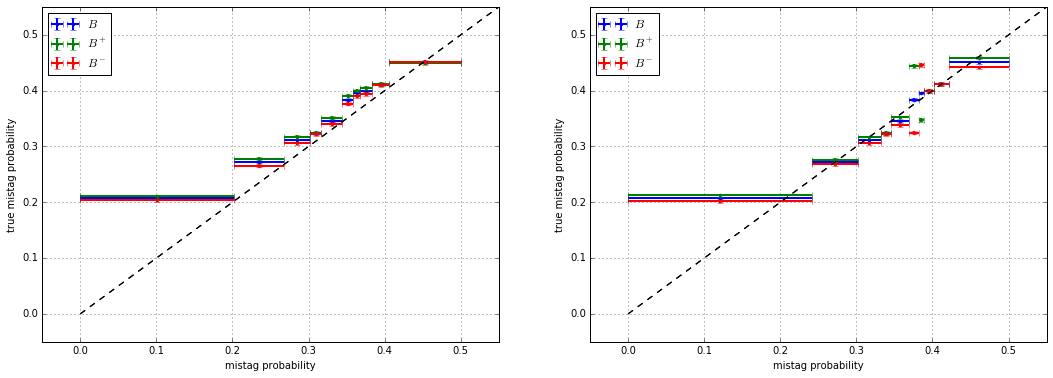

Efficiency, not calibrated 4.28751788421
Average AUC 0.68927653109 2.0273641078e-05


In [ ]:
figsize(18, 7)

results_separate_tmva.append(combine(test_estimators_tmva, datasets, ['K', 'e', 'mu', 'vtx'], 
                                     N_B_events, logistic=True,
                                     model_name='tmva combination'))

### XGBoost

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
AUC for tagged: 0.69675107975 AUC with untag: 0.578736998171


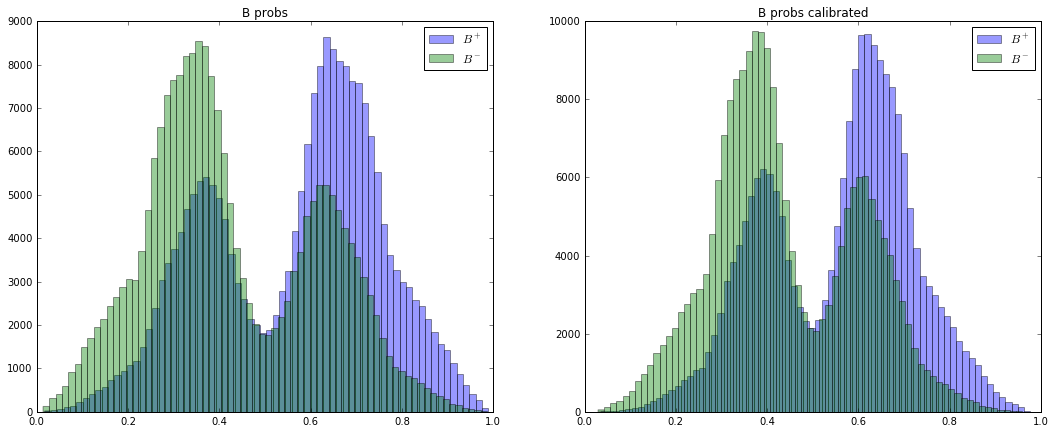

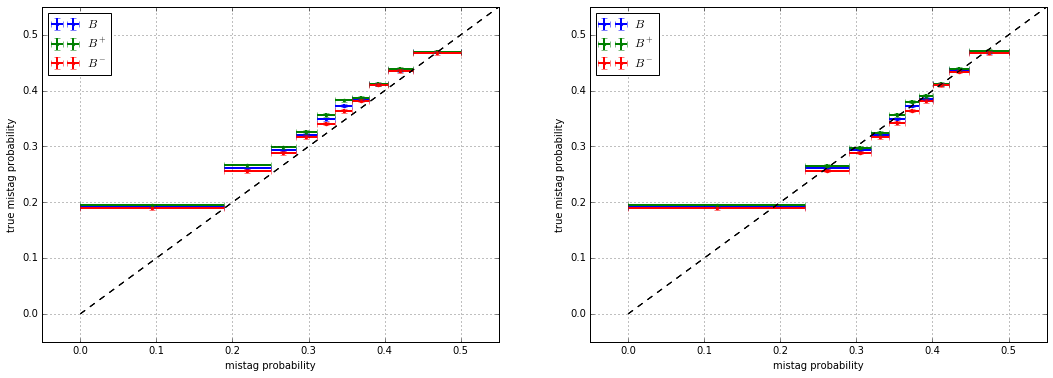

Efficiency, not calibrated 4.64490456184
Average AUC 0.696742230103 1.05324461662e-05


In [ ]:
figsize(18, 7)

x, calibrator_tracks_comb, calibrator_B_comb, roc_curve_old = combine(test_estimators, datasets, 
                                                                      ['K', 'e', 'mu', 'vtx'], N_B_events,
                                                                      logistic=True, return_calibrations=True,
                                                                      model_name='xgboost combination', with_roc=True)
results_separate.append(x)

In [ ]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162675,0.001553,0.822131,0.008400,51.843357,0
0,vtx,12.265035,0.028701,0.099969,0.000478,1.226123,0.006527,53.243263,0
0,K,17.759661,0.034537,0.111957,0.000410,1.988317,0.008241,55.166547,0
0,e,2.023049,0.011657,0.127795,0.001335,0.258536,0.003085,50.658296,0
0,xgboost combination,29.043496,0.044167,0.116340,0.000474,3.378930,0.014692,57.873700,0


## Test combination of taggers on K*

In [ ]:
def prepare_for_epm(estimators, datasets, keys, calibrator_tracks, calibrator_B, N_B_events):
    data_with_predictions = dict()
    for key in keys:
        probs = estimators[key].predict_proba(datasets[key])[:, 1]
        probs_calibrated = calibrator_tracks[key].predict_proba(probs)
    
        data_with_predictions[key] = pandas.DataFrame({'prob_{}'.format(key): probs_calibrated, 
                                                      'tag_{}'.format(key): datasets[key].tagAnswer.values,
                                                      'weight': datasets[key].N_sig_sw.values,
                                                      'signB': datasets[key].signB.values,
                                                      'mass': datasets[key].Bmass.values,
                                                      'time': datasets[key]['time'].values}, 
                                                      index=numpy.array(datasets[key]['event_id']))
        
    tags, Bprobs, Bweights, Bsign, Bmass, Btime = prepare_B_data(data_with_predictions, keys)
    Bprob_calibrated = calibrator_B.predict_proba(Bprobs)
    
    print 'eff: ', 1. * sum(Bweights) / N_B_events
    
    mistag = numpy.minimum(Bprob_calibrated, 1 - Bprob_calibrated)
    tag = numpy.ones(len(Bprob_calibrated))
    tag[Bprob_calibrated < 0.5] = -1

    prepared_data = pandas.DataFrame({'tag': numpy.array(tag, dtype='int32'),
                                      'mistag': mistag,
                                      'flavour': numpy.array(Bsign, dtype='int32'),
                                      'decay_time': Btime,
                                      'Bmass': Bmass,
                                      'resolution': [50*1e-3] * len(Bmass),
                                      'probs': Bprob_calibrated,
                                      'weight': Bweight
                                     })
    return prepared_data

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


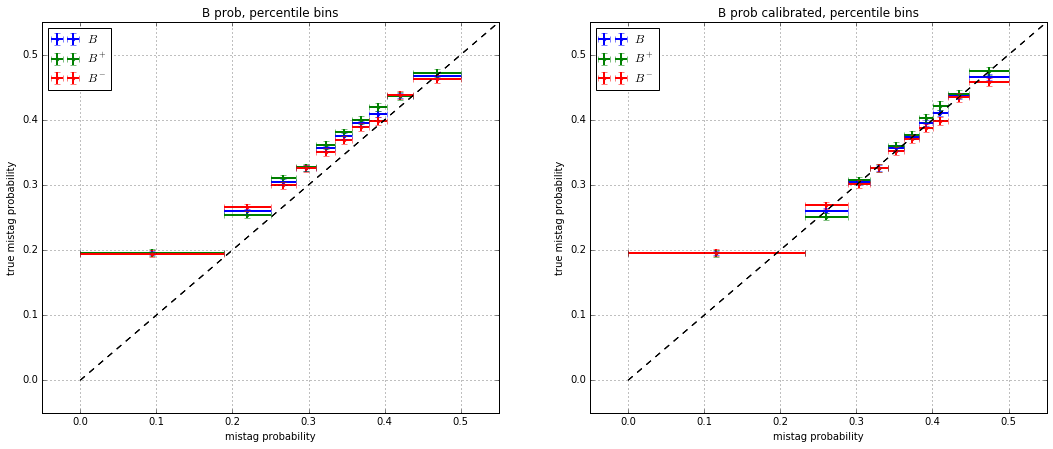

In [ ]:
prepared_kstar = estimate_new_data_old_scheme(test_estimators, datasets_kstar, ['K', 'e', 'mu', 'vtx'],
                                              calibrator_tracks_comb, calibrator_B_comb, N_B_events_kstar)

# Final results

### TMVA

In [ ]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.158149,0.001362,0.799256,0.007474,51.845258,0
0,vtx,12.265035,0.028701,0.084337,0.000383,1.034393,0.005280,53.232109,0
0,K,17.759661,0.034537,0.105538,0.000387,1.874317,0.007774,55.143669,0
0,e,2.023049,0.011657,0.116528,0.001254,0.235741,0.002877,50.659967,0
0,tmva combination,29.043496,0.044167,0.109158,0.000411,3.170318,0.012862,57.778632,0


### XGBoost

In [ ]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162675,0.001553,0.822131,0.008400,51.843357,0
0,vtx,12.265035,0.028701,0.099969,0.000478,1.226123,0.006527,53.243263,0
0,K,17.759661,0.034537,0.111957,0.000410,1.988317,0.008241,55.166547,0
0,e,2.023049,0.011657,0.127795,0.001335,0.258536,0.003085,50.658296,0
0,xgboost combination,29.043496,0.044167,0.116340,0.000474,3.378930,0.014692,57.873700,0


In [ ]:
pandas.concat(results_separate_tmva + results_separate).to_csv(
    '../img/old-tagging-WG.csv', header=True, index=False)

In [ ]:
import cPickle
with open('../models/old-rocs-WG', 'w') as f:
    cPickle.dump(roc_curve_old, f)